# Hierarchical Conditionally Conjugate Infinite Mixture Model with cell-specific scaling parameters
Following Prabhakaran, 2016.

In [1]:
import seaborn as sns
%matplotlib notebook

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

<IPython.core.display.Javascript object>


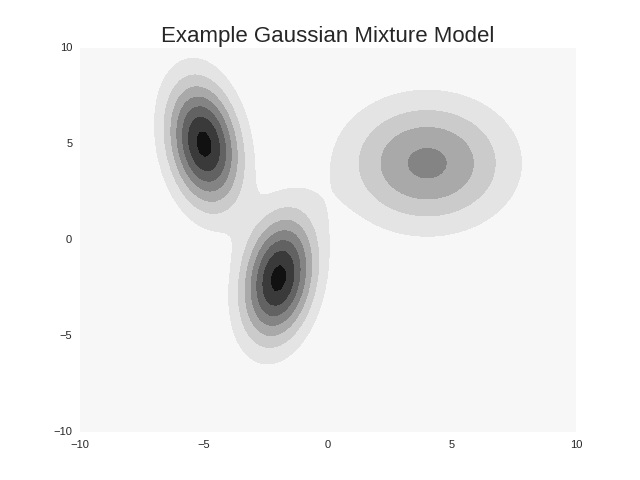

/usr/local/lib/python2.7/dist-packages/pypr/clustering/gmm.py:132: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pdf==None:


In [3]:
# Example GMM
from pypr.clustering import gmm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 100
X = np.linspace(-10, 10, N)
Y = np.linspace(-10, 10, N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
pos = np.concatenate(pos, axis=0)

# Mean vector and covariance matrix
mix = np.array([0.3, 0.3, 0.4])
mu1 = np.array([-2, -2.])
mu2 = np.array([-5, 5.])
mu3 = np.array([4, 4])
Sigma = np.array([[ 1. , 0.5], [0.5,  5.]])
Sigma2 = np.array([[ 1. , -.5], [-.5,  5.]])
Sigma3 = np.array([[ 5. , 0], [0,  5.]])

# The distribution on the variables X, Y packed into pos.
fig = plt.figure()
ax = fig.gca()
plt.contourf(X, Y, gmm.gmm_pdf(pos, [mu1, mu2, mu3], [Sigma, Sigma2, Sigma3], mix).reshape(N, N))
plt.title('Example Gaussian Mixture Model', fontsize=20)
fig.canvas.draw()

In [4]:
# Sample points from the real GMM and estimate a GMM for those points. Hopefully they will be the same!
N = 1000
d = 2
X = gmm.sample_gaussian_mixture([mu1, mu2, mu3], [Sigma, Sigma2, Sigma3], mc=mix, samples=N)
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.show()

<IPython.core.display.Javascript object>

In [5]:
X.shape

(1000, 2)

## The Mixture Model
Let's find a model that describes the generation process of these data. This model will be a **Bayesian Finite Gaussian Mixture Model**. This means it is a sum of $K$ weighted normal distributions (components) parametrized by their means and covariance matrices. Each point in the data set will belong to one of the gaussians.

The parameters we need to estimate are then: the cluster assignment of each data point, the mixture weights and the mean and covariance matrix of each component.

We assign priors to each of these parameters:
* Mixture weights $\mathbf{\pi} = [\pi_1, ..., \pi_K]$ are Dirichlet-distributed, with parameter vector $\mathbf{\alpha} = [\alpha/K, ..., \alpha/K]$;
* Cluster assignments $z_n$ assume values from $1$ to $K$ and are sampled from a discrete distribution with probabilities given by the mixture weights $\mathbf{\pi} = [\pi_1, ..., \pi_K]$;
* The joint prior distribution of the mean and covariance matrix of each component is a Normal-Inverse-Wishart distribution with hyperparameters $\{\mu_0, \lambda\}$ for the Normal, which is prior to the mean, and $\{\Psi, \upsilon\}$ for the inverse-Wishart, which is prior to the covariance matrix.

In [6]:
# Log likelihood
def log_likelihood(data, means, covs, pis, K_active):
    """Data log-likeliehood
    
    Equation 2.153 in Sudderth
    """
    ll = 0
    for i in range(data.shape[0]):
        probs = 0
        for k in range(K_active):
            probs = probs +  pis[k] * multivariate_normal.pdf(data[i], mean=means[k], cov=covs[k])
        ll = ll + np.log10(probs)
        
    return ll

In [7]:
# Resulting GMM
def plot_est_gmm(mu_est, cov_est, pi_est, fig_handler, title=None):
    N = 100
    x = np.linspace(-10, 10, N)
    y = np.linspace(-10, 10, N)
    x, y = np.meshgrid(x, y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    pos = np.concatenate(pos, axis=0)

    z = gmm.gmm_pdf(pos, mu_est, cov_est, pi_est).reshape(N, N)

    # The distribution on the variables X, Y packed into pos.
    ax = fig_handler.gca()
    plt.contourf(x, y, z)
    if title == None:
        title = 'Estimated GMM'
    plt.title(title, fontsize=20)   
    fig_handler.canvas.draw()

In [8]:
K = 20 # truncation of the infinite possible number of clusters
K_aux = 1

# Hyperparameters
# Dirichlet
alpha = 100
alpha_arr = alpha * np.ones((K,))

# NIW
# need [mu0, lam, psi, ups] for each cluster k
mu0 = np.mean(X, axis=0).reshape(1, d)
lam = .2
psi = np.eye(d) * 1.5
ups = d

# Identifiability constraints
min_phi = 1
max_phi = 1
min_beta = 1
max_beta = 1

In [9]:
from scipy.stats import multivariate_normal, wishart, invgamma, invwishart, dirichlet, gamma, norm

In [10]:
X_mean = np.mean(X, axis=0)
X_cov = np.cov(X.T)
X_cov_inv = np.linalg.inv(X_cov)

In [11]:
def prior_hyperparameters():
    mulinha = multivariate_normal.rvs(mean=X_mean, cov=X_cov)
    Sigmalinha = invwishart.rvs(df=d, scale=d * X_cov)
    Hlinha = wishart.rvs(df=d, scale=X_cov / d)
    sigmalinha = invgamma.rvs(1, 1/d) + d
    return mulinha, Sigmalinha, Hlinha, sigmalinha

def prior_mixture_components(mulinha, Sigmalinha, Hlinha, sigmalinha, nsamples=K):
    mu = multivariate_normal.rvs(mean=mulinha, cov=Sigmalinha, size=nsamples).reshape(nsamples, d)
    cov_inv = wishart.rvs(df=sigmalinha, scale=np.linalg.inv(Hlinha), size=nsamples).reshape(nsamples, d, d)
    return mu, cov_inv

def prior_alpha():
    return invgamma.rvs(1, 1)

def prior_pi(alpha, K_active):
    return dirichlet.rvs(alpha/K_active * np.ones((K_active, ))).T

def prior_cell_scalings(ups, delta_sq, omega, theta):
    phi = norm.rvs(ups, delta_sq, size=N)
    beta = invgamma.rvs(omega, theta, size=N)
    return phi, beta

In [12]:
# Sampling from the conditional posteriors
def update_mixture_components(mu, cov_inv, mulinha, Sigmalinha, Hlinha, sigmalinha, z, nk, active):
    K = len(nk)
    for k in range(K): # update all K_active components
        X_k = X[np.argwhere(z==active_components[k]).ravel()] # all the points in current cluster k
        
        Sigmaklinha_inv = np.linalg.inv(Sigmalinha) + nk[k]*cov_inv[k]
        Sigmaklinha = np.linalg.inv(Sigmaklinha_inv)
        muklinha = Sigmaklinha.dot(np.linalg.inv(Sigmalinha).dot(mulinha) + nk[k]*cov_inv[k].dot(np.mean(X_k, axis=0)))
        aux = np.matmul((X_k - mu[k]).T, (X_k - mu[k]))
        
        mu[k] = multivariate_normal.rvs(mean=muklinha, cov=Sigmaklinha)
        cov_inv[k] = wishart.rvs(df=int(np.ceil(sigmalinha)) + nk[k] + 1, scale=np.linalg.inv(Hlinha + aux))
    return mu, cov_inv

# the hyperparameters are the same for all mixture components
def update_hyperparameters(mu, cov_inv, mulinha, Sigmalinha, Hlinha, sigmalinha):
    K = len(nk)
    
    # mulinha
    Sigmalinha_inv = np.linalg.inv(Sigmalinha)
    covariance = np.linalg.inv(X_cov_inv + K * Sigmalinha_inv)
    mean = covariance.dot(K**2 * Sigmalinha_inv.dot(np.mean(mu, axis=0)) + X_cov_inv.dot(X_mean))
    mulinha = multivariate_normal.rvs(mean=mean, cov=covariance)
    
    # Sigmalinha
    aux = np.matmul((mu - mulinha).T, mu - mulinha)
    Sigmalinha = np.linalg.inv(wishart.rvs(df=d+K, scale=np.linalg.inv(d*X_cov_inv + 2*aux)))
    
    # Hlinha
    Hlinha = invwishart.rvs(df=d + K*sigmalinha, scale=d*X_cov_inv + np.sum(cov_inv, axis=0))
    
    # sigmalinha
    sigmalinha = invgamma.rvs(1, 1/d)
    
    return mulinha, Sigmalinha, Hlinha, sigmalinha 

def update_alpha():
    return invgamma.rvs(1, 1)

def update_pi(alpha, nk):
    return dirichlet.rvs(alpha/len(nk) * np.ones((len(nk), )) + nk).T

In [13]:
def cluster_probs_at_point(x, means, cov_invs, pis, K_active):
    probs = [(pis[k] * multivariate_normal.pdf(x, mean=means[k], cov=np.linalg.inv(cov_invs[k]))) for k in range(K_active)]
    probs = probs / np.sum(probs)
    return probs

def prior_update_z(mu, cov_inv, pi, K_active):
    for n in range(N):
        probs = np.array(cluster_probs_at_point(X[n], mu, cov_inv, pi, K_active)).ravel()
        z[n] = np.random.choice(range(K_active), p=probs)
    return z

In [14]:
mulinha_, Sigmalinha_, Hlinha_, sigmalinha_ = prior_hyperparameters()
means, covariance_invs = prior_mixture_components(mulinha_, Sigmalinha_, Hlinha_, sigmalinha_, nsamples=1)
covariances = np.linalg.inv(covariance_invs)
multivariate_normal.pdf(X[0], mean=means[0], cov=covariances[0])

3.2214056074757099e-288

In [15]:
means

array([[-16.09586427,   3.00332011]])

In [23]:
# Updating z in the infinite mixture case
def update_z_inf(K_active, K_aux, nk, mu, cov_inv, alpha, phi, beta, active_components):
    mulinha_, Sigmalinha_, Hlinha_, sigmalinha_ = prior_hyperparameters()
    for n in range(N):
        if nk[np.argwhere(active_components==z[n])] == 1:
            z[n] = np.random.choice(range(K_active, K_active + K_aux))
            continue
        
        means, covariance_invs = prior_mixture_components(mulinha_, Sigmalinha_, Hlinha_, sigmalinha_, nsamples=K_aux)
        covariances = np.linalg.inv(covariance_invs)

        probs = np.ones((K_active + K_aux,))
        for k_active in range(K_active):
            probs[k_active] = (nk[k_active] - 1)/(N - 1 + alpha) * multivariate_normal.pdf(X[n], mean=phi[n] * mu[k_active], cov=beta[n] * np.linalg.inv(cov_inv[k_active]))

        for k_aux in range(K_aux):
            probs[K_active + k_aux] = (alpha/K_aux)/(N - 1 + alpha) * multivariate_normal.pdf(X[n], mean=phi[n] * means[k_aux], cov=beta[n] * covariances[k_aux])
            
        probs = probs / np.sum(probs)
        
        z[n] = np.random.choice(range(K_active + K_aux), p=probs)
        
    return z

def update_counts(z):
    nk = np.ones((K, ))
    for k in range(K):
        nk[k] = np.count_nonzero(z == k)
    return nk

def update_pi(alpha, nk):
    return dirichlet.rvs(alpha/len(nk) * np.ones((len(nk), )) + nk).T

def get_active_components(nk):
    active_clusters = []
    for k in range(K):
        if nk[k] > 0:
            active_clusters.append(k)
    return active_clusters, len(active_clusters)

def add_new_components(active, mu, cov_inv, pi):
    if np.any(np.array(active) > mu.shape[0] - 1): # need to grow the vectors!
        new_max = max(active) + 1
        mu_new = np.zeros((new_max, d))
        mu_new[:-1,:] = mu
        cov_inv_new = np.zeros((new_max, d, d))
        cov_inv_new[:-1,:,:] = cov_inv
        pi_new = np.zeros((new_max, 1))
        pi_new[:-1] = pi
        return mu_new, cov_inv_new, pi_new
    else:
        return mu, cov_inv, pi

def remove_empty_components(active, nk, mu, cov_inv, pi):
    new_nk = nk[active]
    new_mu = mu[active]
    new_cov_inv = cov_inv[active]
    new_pi = pi[active]
    new_pi = new_pi / np.sum(new_pi)
    return new_nk, new_mu, new_cov_inv, new_pi

In [37]:
def update_cell_scalings(phi, beta, mu, cov_inv, z, ups, delta_sq, omega, theta, active):
    for n in range(N):
        k = np.argwhere(active == z[n])[0][0]
        
        # Update phi
        A = 1./np.sqrt(beta[n] * np.abs(cov_inv[k]))
        A_mu_k = A.dot(mu[k])
        delta_xsq = 1./np.sum(A_mu_k)
        
        A_x_j = A.dot(X[n])
        ups_x = delta_xsq * np.sum(A_x_j.dot(A_mu_k))
        
        delta_psq = np.abs(1./((1./delta_xsq) + 1./(delta_sq)))
        ups_p = np.abs(delta_psq * (ups_x / delta_xsq + ups/delta_sq))
        phi[n] = norm.rvs(ups_p, delta_psq)

        # identifiability constraint on phi
        if phi[n] < min_phi:
            phi[n] = min_phi + norm.rvs(0, 0.1)
        elif phi[n] > max_phi:
            phi[n] = max_phi - norm.rvs(0, 0.1)
        
        # Update beta
        omega_p = omega + d/2.
        theta_p = np.abs(theta + 0.5 * np.matmul(np.matmul((X[n] - phi[n]*mu[k]).T, cov_inv[k]), X[n] - phi[n]*mu[k]))
        
        beta[n] = invgamma.rvs(omega_p, theta_p)
        
        # identifiability constraint on beta
        if beta[n] < min_beta:
            beta[n] = min_beta + invgamma.rvs(omega_p, 1./omega_p)
        elif beta[n] > max_beta:
            beta[n] = np.abs(max_beta - invgamma.rvs(omega_p, 1./omega_p))
        
    return phi, beta

In [41]:
# Assignment vector: N x 1
z = np.zeros((N,))

# Number of data points per cluster:
nk = np.zeros((K,))

# Mixture weights vector: K x 1
pi = np.zeros((K,))

# Mean vector: K x d
mu = np.zeros((K, d))

# Covariance matrix: K x d x d
cov_inv = np.zeros((K, d, d))

# Cell-specific moment scaling parameters
# phi: N x 1
phi = np.zeros((N,))

# beta: N x 1
beta = np.zeros((N,))

<IPython.core.display.Javascript object>


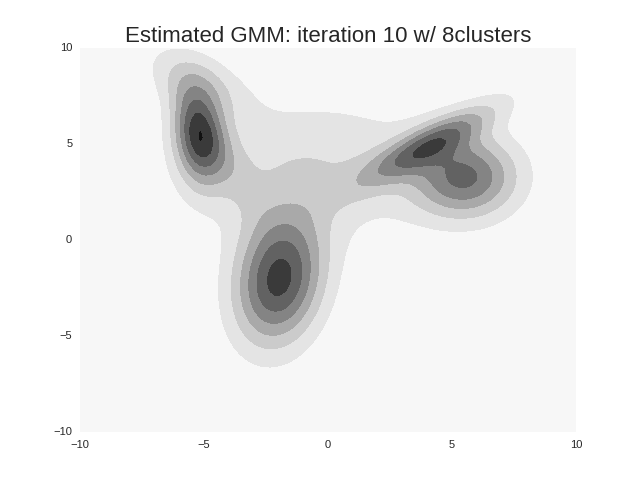

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


LinAlgError: singular matrix

In [43]:
z_runlist = []
pi_runlist = []
mu_runlist = []
cov_inv_runlist = []

save_plot = False
path = 'figures/'

# fig1 = plt.figure(4)
# ax = fig1.add_subplot(111)
# plt.ion() 
# fig1.show()
# fig1.canvas.draw()

fig2 = plt.figure(5)
ax = fig2.add_subplot(111)
plt.ion() 
fig2.show()
fig2.canvas.draw()

# Gibbs sampling iterations
niterations = 150

# Keep track of the log-likelihood of the estimated model during sampling
lls = np.ones((niterations, 1))

# Initialize parameters with samples from the prior distributions
# the hyperparameters are the same for all mixture components
K_active = 1

ups = 1
delta_sq = 1
omega = 1
theta = 1

mulinha, Sigmalinha, Hlinha, sigmalinha = prior_hyperparameters()  
mu, cov_inv = prior_mixture_components(mulinha, Sigmalinha, Hlinha, sigmalinha, nsamples=K_active)  
alpha = prior_alpha()
pi = prior_pi(alpha, K_active)
z = prior_update_z(mu, cov_inv, pi, K_active)
nk = update_counts(z)
active_components, K_active = get_active_components(nk)
nk, mu, cov_inv, pi = remove_empty_components(active_components, nk, mu, cov_inv, pi) # The parameter vectors are now of length K_active
phi, beta = prior_cell_scalings(ups, delta_sq, omega, theta)

for i in range(0, niterations): 
    # Sampling from the conditional posteriors    
    alpha = update_alpha()
    pi = update_pi(alpha, nk)
    
    mu, cov_inv = update_mixture_components(mu, cov_inv, mulinha, Sigmalinha, Hlinha, sigmalinha, z, nk, active_components)
    
    phi, beta = update_cell_scalings(phi, beta, mu, cov_inv, z, ups, delta_sq, omega, theta, active_components)
    
#     print('\nIteration %d' % i)
#     print('nk', nk)
#     print('pi', pi)
#     print('mu', mu)
#     print('cov', np.linalg.inv(cov_inv)) 
    
#     lls[i] = log_likelihood(X, mu, np.linalg.inv(cov_inv), pi, K_active)
    
#     plt.figure(4)
#     plt.gcf().clear()
#     plt.plot(lls[:i])
#     plt.xlabel("iteration")
#     plt.title('Log-likelihood')
#     fig1.canvas.draw()
    
    plt.figure(5)
    plt.gcf().clear()
    plot_est_gmm(mu, np.linalg.inv(cov_inv), pi, fig2, title='Estimated GMM: iteration ' + str(i) + ' w/ ' + str(K_active) + 'clusters')
    if save_plot:
        plt.savefig(path + str(i) + '.jpg')
    
    # the hyperparameters are the same for all mixture components
    mulinha, Sigmalinha, Hlinha, sigmalinha = update_hyperparameters(mu, cov_inv, mulinha, Sigmalinha, Hlinha, sigmalinha)    
    
    z = update_z_inf(K_active, K_aux, nk, mu, cov_inv, alpha, phi, beta, active_components)
    nk = update_counts(z)
    active_components, K_active = get_active_components(nk)
    mu, cov_inv, pi = add_new_components(active_components, mu, cov_inv, pi)
    nk, mu, cov_inv, pi = remove_empty_components(active_components, nk, mu, cov_inv, pi) # The parameter vectors are now of length K_active
        
    z_runlist.append(z)
    pi_runlist.append(pi)
    mu_runlist.append(mu)
    cov_inv_runlist.append(cov_inv)

In [51]:
np.count_nonzero(beta)

1000

# Data imputation
Generate data Y according to a GMM, apply cell-specific scalings to it to obtain X and learn a DPGMM from X. After learning the parameters for the X-generating DPGMM, transform X to Y using those parameters.

In [ ]:
mix = np.array([0.3, 0.3, 0.4])
mu1 = np.array([-2, -2.])
mu2 = np.array([-5, 5.])
mu3 = np.array([4, 4])
Sigma = np.array([[ 1. , 0.5], [0.5,  5.]])
Sigma2 = np.array([[ 1. , -.5], [-.5,  5.]])
Sigma3 = np.array([[ 5. , 0], [0,  5.]])

In [ ]:
X = gmm.sample_gaussian_mixture([mu1, mu2, mu3], [Sigma, Sigma2, Sigma3], mc=mix, samples=N)